<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/PCA_1DCNN_(binary_classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CICIDS2017 Dataset

Extraction

In [ ]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
print(cicids2017_df.head().to_string())
print(cicids2017_df.info())

# --- Label Encoding ---

cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].apply(lambda x: 0 if x == 'Normal Traffic' else 1)


Initial samples:
cicids2017_df shape: (2520751, 53)
   Destination Port  Flow Duration  Total Fwd Packets  Total Length of Fwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  Flow Packets/s  Flow IAT Mean   Flow IAT Std  Flow IAT Max  Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  Min Packet Length  Max Packet Length  Packet Length Mean  Packet Length Std  Packet Length Variance  FIN Flag Count  PSH Flag Count  ACK Flag Count  Average Packet Size  Subflow Fwd Bytes  Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  min_seg_size_forward  Active Mean  Active Max  Active Min  Idle Mean  Idle Max  Idle Min     Attack Type
0                22     

#Data Split

Input Shapes -> Train: (1209960, 52), Val: (302490, 52), Test: (1008301, 52)
Labels[Benign, Mal] -> Train: [1005627  204333], Val: [251407  51083], Test: [838023 170278]


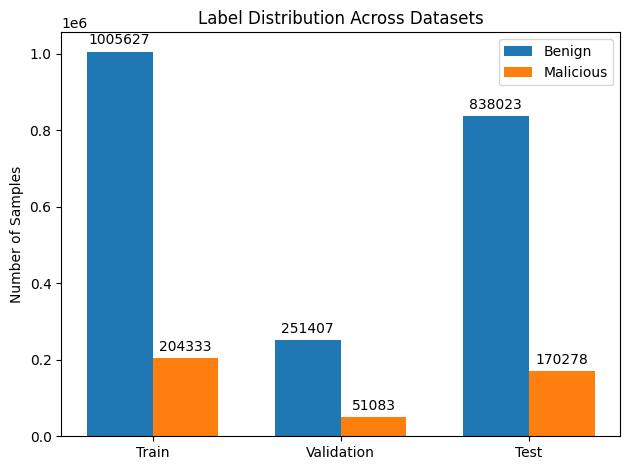

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

# --- Train/val/test split ---
# Split label from datafram
X = cicids2017_df.drop('Attack Type', axis=1)
y = cicids2017_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X, y, test_size=0.4, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify = y_temp)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# --- Visualisation ---
print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Labels[Benign, Mal] -> Train: {np.bincount(y_train)}, Val: {np.bincount(y_val)}, Test: {np.bincount(y_test)}")

train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Data for plotting
labels = ['Benign', 'Malicious']
datasets = ['Train', 'Validation', 'Test']
counts = [train_counts, val_counts, test_counts]

# Transpose counts to group by label
benign_counts = [c[0] for c in counts]
mal_counts = [c[1] for c in counts]

x = np.arange(len(datasets))  # the label locations
width = 0.35  # width of the bars

# Plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, benign_counts, width, label='Benign')
rects2 = ax.bar(x + width/2, mal_counts, width, label='Malicious')

# Add labels
ax.set_ylabel('Number of Samples')
ax.set_title('Label Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#Normalisation

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import numpy as np

# --- Normalize ---
#scaler = RobustScaler() # Initialize the scaler
#scaler = StandardScaler() # Initialize the scaler
scaler = MinMaxScaler() # Initialize the scaler


# Apply the scaler
X_train_scaled = scaler.fit_transform(X_train) # Standardise data features
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train_scaled.shape}")
print(f"Shape of X_val after scaling: {X_val_scaled.shape}")
print(f"Shape of X_test after scaling: {X_test_scaled.shape}")

Shape of X_train after scaling: (1209960, 52)
Shape of X_val after scaling: (302490, 52)
Shape of X_test after scaling: (1008301, 52)


#Apply PCA
Principal component analysis (PCA) is a dimensionality reduction and unsuprevised machine learning method used to simplify a large data set into a smaller set while still maintaining
significant patterns and trends.
Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first

In [ ]:
from sklearn.decomposition import PCA

# Make an instance of the pca Model
pca = PCA(0.95) # sklearn chooses the minimum number of principal components such that 95 percent of the variance in the data is retained
#pca = PCA(n_components = 10)

# Only fit the PCA to the training data
pcaX_train = pca.fit_transform(X_train_scaled)#To avoid data leakage (information from the test set influences the model during training)
print(f"principle components: {pca.n_components_}")

pcaX_val = pca.transform(X_val_scaled)
pcaX_test = pca.transform(X_test_scaled)# Apply the PCA to the test data


principle components: 9


#Visualise PCA
https://plotly.com/python/pca-visualization/

In [ ]:
# import plotly.express as px
# import pandas as pd

# pcaX_train_features = []

# for i in range(pca.n_components_):
#   pcaX_train_features.append(f'PC{i+1}')

# print(f"PCA features: {pcaX_train_features}")

# # Create a DataFrame from the PCA results with column names
# pca_train_df = pd.DataFrame(data=pcaX_train, columns=pcaX_train_features)

# # Add the original labels for coloring
# pca_train_df['label'] = y_train

# fig = px.scatter_matrix(
#      pca_train_df,
#      dimensions= pcaX_train_features,
#      color="label"
# )
# fig.update_traces(diagonal_visible=False)
# fig.show()

In [ ]:
import pandas as pd
import plotly.express as px


# Make sure labels are strings "Mal" and "Normal"
# If y_train is numeric (e.g., 0,1), map it:
label_map = {0: 'Benign', 1: 'Malicious'}
pca_train_df['Label'] = [label_map[label] if label in label_map else label for label in y_train]

explained_var = pca.explained_variance_ratio_ * 100

# Define color mapping explicitly
color_discrete_map = {
    'Mal': 'red',
    'Normal': 'blue'
}

fig = px.scatter(
    pca_train_df,
    x='PC1',
    y='PC2',
    color='Label',
    color_discrete_map=color_discrete_map,
    title=f'PCA Scatter Plot: PC1 ({explained_var[0]:.2f}%) & PC2 ({explained_var[1]:.2f}%) Variance Explained',
    labels={
        'PC1': f'PC1 ({explained_var[0]:.2f}%)',
        'PC2': f'PC2 ({explained_var[1]:.2f}%)',
        'Label': 'Label'
    }
)

fig.show()

# Data reshaping for 1D CNN input

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

# Reshape the data so it can be used as input for the 1D CNN
# 1D CNN expects input shape: (samples, timesteps, features). timesteps = number of features, features = 1 (per timestep)
X_train = pcaX_train.reshape((pcaX_train.shape[0], pcaX_train.shape[1], 1))
X_val = pcaX_val.reshape((pcaX_val.shape[0], pcaX_val.shape[1], 1))
X_test = pcaX_test.reshape((pcaX_test.shape[0], pcaX_test.shape[1], 1))

# --- Final Shape Confirmation ---
print("Training input shape:", X_train.shape)
print("Validation input shape:", X_val.shape)
print("Test input shape:", X_test.shape)

Training input shape: (1209960, 9, 1)
Validation input shape: (302490, 9, 1)
Test input shape: (1008301, 9, 1)


#1D CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

# Define the 1D CNN Model

# Define input shape
input_shape = (X_train.shape[1], 1)  # (timesteps, features)

# Build model
model = Sequential([
    Input(shape=input_shape),
    Conv1D(filters=32, kernel_size=3, activation='relu'), # Detect patterns in the network traffic data
    BatchNormalization(), # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
    MaxPooling1D(pool_size=2), # Reduce the dimensions of the data without affecting key features
    Dropout(0.25), # Prevent overfitting by forcing the model to generalize - it does this by randomly deactivating a fraction of neurons during training

    Conv1D(filters=64, kernel_size=2, activation='relu'),#kernel_size=3
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(), # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
    Dropout(0.5), # Randomly drop 50% of the network;s neurons to further prevent overfitting
    Dense(1, activation='sigmoid')  # Final output layer( 1 = 1 neuron for binary classification, sigmoid = decides if input is malicious (1) or benign (0))
])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Loss function measures how well the model’s predictions match true labels

#Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,897 (34.75 KB)

 Trainable params: 8,705 (34.00 KB)

 Non-trainable params: 192 (768.00 B)

#Train 1D CNN

Epoch 1/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.9428 - loss: 0.1415 - val_accuracy: 0.9601 - val_loss: 0.0829
Epoch 2/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9582 - loss: 0.0916 - val_accuracy: 0.9671 - val_loss: 0.0795
Epoch 3/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9590 - loss: 0.0889 - val_accuracy: 0.9654 - val_loss: 0.0799
Epoch 4/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 92s 4ms/step - accuracy: 0.9594 - loss: 0.0867 - val_accuracy: 0.9666 - val_loss: 0.0760
Epoch 5/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - accuracy: 0.9609 - loss: 0.0847 - val_accuracy: 0.9666 - val_loss: 0.0725
Epoch 6/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 73s 4ms/step - accuracy: 0.9632 - loss: 0.0823 - val_accuracy: 0.9669 - val_loss: 0.0724
Epoch 7/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 72s 3ms/step - accuracy: 0.9624 - loss: 0.0824 - val_accuracy: 0.9632 - val_loss: 0.0803
Epoch 8/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 

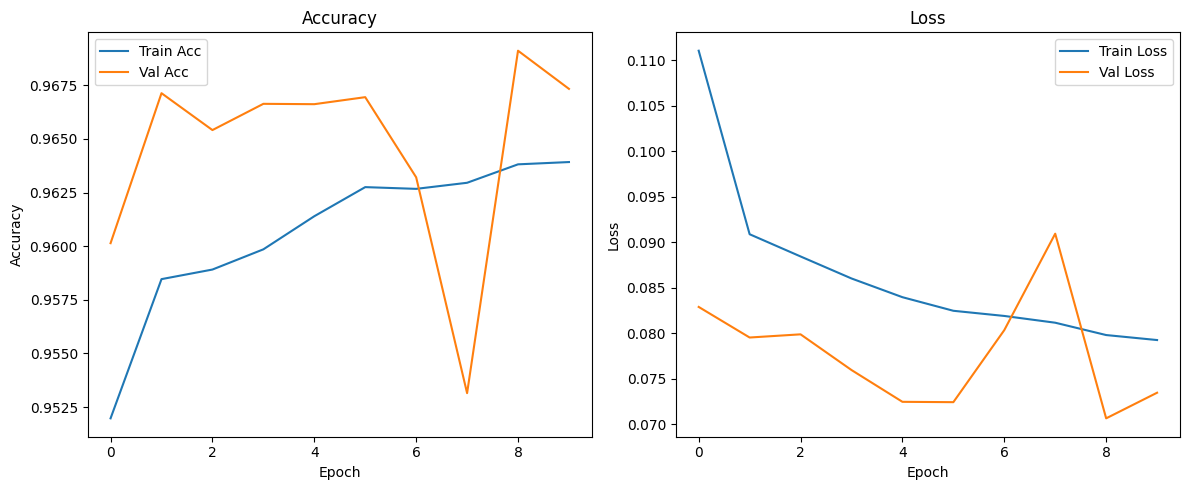

In [ ]:
import matplotlib.pyplot as plt
import timeit

# Train the Model
start_time = timeit.default_timer()
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)
end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plot accuracy and loss
plt.figure(figsize=(12,5)) # Create a new figure that is 12x5

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Get predictions of x_test dataset
threshold = 0.5
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > threshold).astype(int).flatten()  # Convert probabilities to 0 or 1, 0.5 = Threshold

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: print as table
print("Confusion Matrix:")
print(cm)

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as malware): {fp}")
print(f"False Negatives (Malware missed): {fn}")
print(f"True Positives (Malware correctly identified): {tp}")

# Accuracy scores
print("Accuracy:")
print("sklearn Accuracy:", accuracy_score(y_test, y_pred))
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)# Evaluate model with test set
print(f"model.evaluate Accuracy: {test_acc:.4f}")
print(f"Confusion Matrix Accuracy: {(tp + tn) / (tp + tn + fp + fn)}")
print(f"{(tp/(tp+fn))*100}% of malware idenetified")

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

31510/31510 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step
Confusion Matrix:
[[813540  24483]
 [  8772 161506]]

True Negatives (Benign correctly classified): 813540
False Positives (Benign misclassified as malware): 24483
False Negatives (Malware missed): 8772
True Positives (Malware correctly identified): 161506
Accuracy:
sklearn Accuracy: 0.9670187771310352
model.evaluate Accuracy: 0.9670
 Confusion Matrix Accuracy: 0.9670187771310352

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.97      0.98    838023
   Malicious       0.87      0.95      0.91    170278

    accuracy                           0.97   1008301
   macro avg       0.93      0.96      0.94   1008301
weighted avg       0.97      0.97      0.97   1008301



#Visualisation of results ?

/tmp/ipython-input-11-1066283020.py:39: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



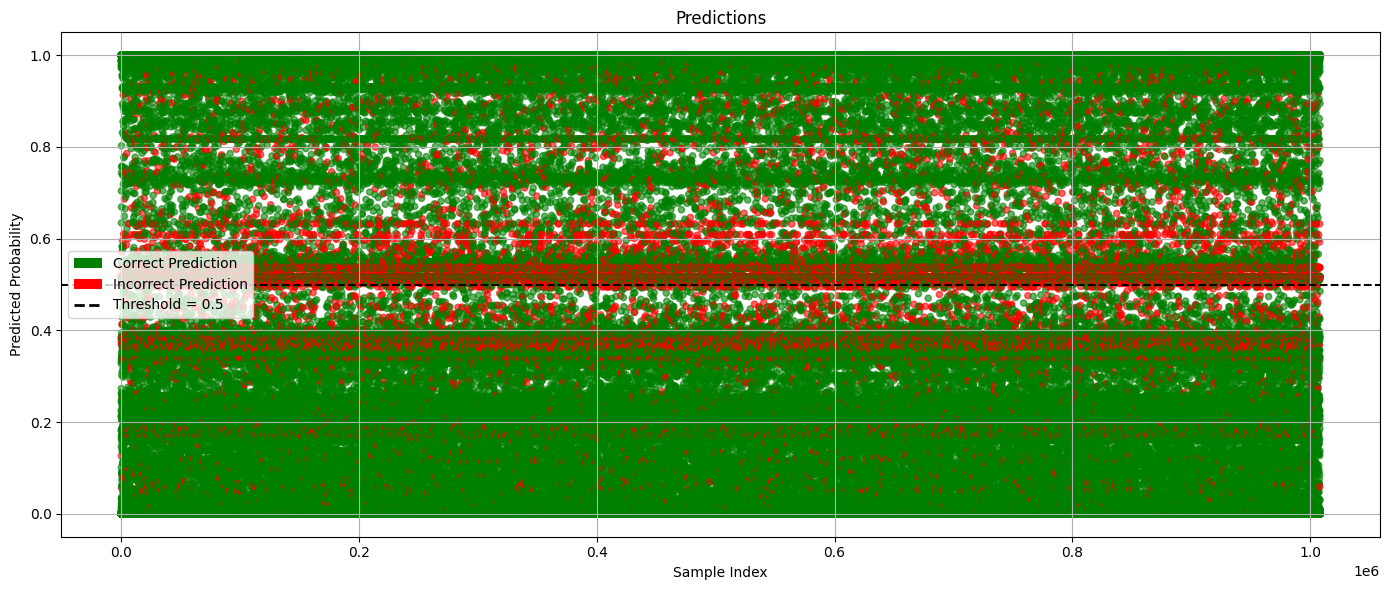

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Create x-axis index
x = np.arange(len(y_pred_probs))

# y_pred: predicted labels from the model (e.g., [0, 1, 1, 0])
# y_test: true labels (e.g., [0, 1, 0, 1])

# Check if each prediction is correct
correct_predictions = y_pred == y_test # If y_pred[i] == y_test[i] then correct_predictions = True, else correct_predictions = False
colors = []
for is_correct in correct_predictions: # If correct_predictions is True, use 'green' else use 'red'
    if is_correct:
        colors.append('green')  # Correct prediction
    else:
        colors.append('red')    # Incorrect prediction

# Make scatter plot
plt.figure(figsize=(14, 6))
plt.scatter(x, y_pred_probs, c=colors, alpha=0.6, s=20) #plot a point (y_pred_probs), if the y_pred is true for that point, then colour the point green
plt.axhline(y=threshold, color='black', linestyle='--', linewidth=1.5)

# Add combined legend
legend_elements = [
    Patch(facecolor='blue', label='Correct Prediction'),
    Patch(facecolor='red', label='Incorrect Prediction'),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Threshold = 0.5')
]
plt.legend(handles=legend_elements)

# Labels and styling
plt.title("Predictions")
plt.xlabel("Sample Index") # position of each test sample in the X_test dataset
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.tight_layout()
plt.show()
